In [82]:
import pandas as pd   
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns  
import category_encoders as ce   
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import shapiro, normaltest, probplot
import joblib

dft = pd.read_csv('Titanic Personal Data.csv')   
dfp = pd.read_csv('Titanic Ticket Data.csv')     
# Merge the dataframes on PassengerId
Titanic_data = dft.merge(dfp, on='PassengerId', how='inner')

# Initial exploration
print(Titanic_data.head())
print(Titanic_data.shape)
print(Titanic_data.info())
print(Titanic_data.isnull().sum())


   PassengerId                                               Name     Sex  \
0            1                            Braund, Mr. Owen Harris    male   
1            2  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   
2            3                             Heikkinen, Miss. Laina  female   
3            4       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
4            5                           Allen, Mr. William Henry    male   

    Age  SibSp  Parch   Salary         Job  Survived            Ticket  \
0  22.0      1      0   399.69    wigmaker         0         A/5 21171   
1  38.0      1      0  3914.60      doctor         1          PC 17599   
2  26.0      0      0   370.30  blacksmith         1  STON/O2. 3101282   
3  35.0      1      0  3802.80     surgeon         1            113803   
4  35.0      0      0   330.62      barber         0            373450   

      Fare Cabin Embarked  
0   7.2500   NaN        S  
1  71.2833   C85        C  
2   7.92

In [83]:
print(Titanic_data.isnull().sum())

PassengerId      0
Name             0
Sex              0
Age            242
SibSp            0
Parch            0
Salary           0
Job              0
Survived         0
Ticket           0
Fare             1
Cabin          934
Embarked         2
dtype: int64


In [84]:
Titanic_data.columns

Index(['PassengerId', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Salary', 'Job',
       'Survived', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [85]:
Titanic_data.dropna(subset=["Embarked", "Fare"], inplace=True)
print(Titanic_data.isnull().sum())

Titanic_data["Age"] = Titanic_data["Age"].fillna(-0.5)

Titanic_data['Title'] = Titanic_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

Titanic_data['Title'] = Titanic_data['Title'].replace(
    ['Lady', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare'
)
Titanic_data['Title'] = Titanic_data['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
Titanic_data['Title'] = Titanic_data['Title'].replace('Mlle', 'Miss')
Titanic_data['Title'] = Titanic_data['Title'].replace('Ms', 'Miss')
Titanic_data['Title'] = Titanic_data['Title'].replace('Mme', 'Mrs')

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
Titanic_data['Title'] = Titanic_data['Title'].map(title_mapping)

Titanic_data["Age"] = Titanic_data["Age"].replace(-0.5, np.nan)

mode_age_by_title = Titanic_data.groupby('Title')['Age'].agg(lambda x: x.mode()[0])
Titanic_data.loc[Titanic_data['Age'].isnull(), 'Age'] = \
    Titanic_data.loc[Titanic_data['Age'].isnull(), 'Title'].map(mode_age_by_title)

bins = [0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
Titanic_data['AgeGroup'] = pd.cut(Titanic_data["Age"], bins, labels=labels)

Titanic_data['HasCabin'] = Titanic_data['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)
Titanic_data['Deck'] = Titanic_data['Cabin'].astype(str).str[0]
Titanic_data['Deck'] = Titanic_data['Deck'].replace('n', 'U')  # Unknown

Titanic_data = Titanic_data.drop('Cabin', axis=1)

Titanic_data['Age'] = Titanic_data['Age'].clip(upper=80)
Titanic_data['SibSp'] = Titanic_data['SibSp'].clip(upper=8)
Titanic_data['Parch'] = Titanic_data['Parch'].clip(upper=6)

Titanic_data['Fare'] = Titanic_data['Fare'].apply(lambda x: np.log1p(x))
Titanic_data['Salary'] = Titanic_data['Salary'].clip(
    upper=Titanic_data['Salary'].quantile(0.99)
)
Titanic_data['Salary'] = np.log1p(Titanic_data['Salary'])  

Titanic_data['FamilySize'] = Titanic_data['SibSp'] + Titanic_data['Parch'] + 1
Titanic_data['FamilySizeEncoded'] = pd.cut(
    Titanic_data['FamilySize'],
    bins=[0, 1, 4, float('inf')],
    labels=[0, 1, 2],
    right=True
).astype(int)


PassengerId      0
Name             0
Sex              0
Age            242
SibSp            0
Parch            0
Salary           0
Job              0
Survived         0
Ticket           0
Fare             0
Cabin          933
Embarked         0
dtype: int64


In [86]:
print(Titanic_data.isnull().sum())

PassengerId          0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Salary               0
Job                  0
Survived             0
Ticket               0
Fare                 0
Embarked             0
Title                0
AgeGroup             0
HasCabin             0
Deck                 0
FamilySize           0
FamilySizeEncoded    0
dtype: int64


In [87]:
Titanic_data['Deck'].value_counts()

Deck
U    933
C     86
B     59
D     42
E     37
F     20
A     18
G      5
T      1
Name: count, dtype: int64

In [88]:
deck_counts = Titanic_data['Deck'].value_counts()
print(deck_counts)


Deck
U    933
C     86
B     59
D     42
E     37
F     20
A     18
G      5
T      1
Name: count, dtype: int64


In [89]:
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
import pandas as pd
import numpy as np

binary_encoder = ce.BinaryEncoder(cols=['Job'])
Titanic_data = binary_encoder.fit_transform(Titanic_data)

one_hot_columns = ['Sex', 'Embarked', 'Title']
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_one_hot = pd.DataFrame(
    one_hot_encoder.fit_transform(Titanic_data[one_hot_columns]),
    columns=one_hot_encoder.get_feature_names_out(one_hot_columns),
    index=Titanic_data.index
)
Titanic_data = Titanic_data.drop(columns=one_hot_columns).join(encoded_one_hot)

deck_mapping = {
    'A': 'Upper',
    'B': 'Upper',
    'C': 'Upper',
    'D': 'Middle',
    'E': 'Middle',
    'F': 'Lower',
    'G': 'Lower',
    'T': 'Lower',   
    'U': 'Unknown' 
}

Titanic_data['DeckGroup'] = Titanic_data['Deck'].map(deck_mapping)

Titanic_data = pd.get_dummies(Titanic_data, columns=['DeckGroup'], prefix='DeckGroup', drop_first=False)

Titanic_data = Titanic_data.drop('Deck', axis=1)

label_encoder = LabelEncoder()
Titanic_data['AgeGroup_encoded'] = label_encoder.fit_transform(Titanic_data['AgeGroup'])
Titanic_data = Titanic_data.drop(columns=['AgeGroup'])

Titanic_data = Titanic_data.drop(columns=['PassengerId', 'Name', 'Ticket'], axis=1)

Titanic_data['Salary_log'] = np.log1p(Titanic_data['Salary'])
Titanic_data = Titanic_data.drop('Salary', axis=1)

columns_to_normalize = ['Age', 'SibSp', 'Parch', 'Fare', 'Salary_log']
scaler = MinMaxScaler()
Titanic_data[columns_to_normalize] = scaler.fit_transform(Titanic_data[columns_to_normalize])

Titanic_data['FareBin'] = pd.cut(Titanic_data['Fare'], bins=3, labels=['Low', 'Medium', 'High'])

if 'FamilySize' in Titanic_data.columns:
    Titanic_data = Titanic_data.drop(columns=['Fare', 'FamilySize'], axis=1)
else:
    Titanic_data = Titanic_data.drop(columns=['Fare'], axis=1)

Titanic_data = pd.get_dummies(Titanic_data, columns=['FareBin'], drop_first=True)

columns_to_drop = ['Parch', 'SibSp']
for col in columns_to_drop:
    if col in Titanic_data.columns:
        Titanic_data = Titanic_data.drop(col, axis=1)

print(Titanic_data.head())


        Age  Job_0  Job_1  Job_2  Job_3  Job_4  Survived  HasCabin  \
0  0.287881      0      0      0      0      1         0         0   
1  0.498879      0      0      0      1      0         1         1   
2  0.340630      0      0      0      1      1         1         0   
3  0.459317      0      0      1      0      0         1         1   
4  0.459317      0      0      1      0      1         0         0   

   FamilySizeEncoded  Sex_male  ...  Title_5  Title_6  DeckGroup_Lower  \
0                  1       1.0  ...      0.0      0.0            False   
1                  1       0.0  ...      0.0      0.0            False   
2                  0       0.0  ...      0.0      0.0            False   
3                  1       0.0  ...      0.0      0.0            False   
4                  0       1.0  ...      0.0      0.0            False   

   DeckGroup_Middle  DeckGroup_Unknown  DeckGroup_Upper  AgeGroup_encoded  \
0             False               True            False  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


In [90]:
Titanic_data.columns

Index(['Age', 'Job_0', 'Job_1', 'Job_2', 'Job_3', 'Job_4', 'Survived',
       'HasCabin', 'FamilySizeEncoded', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'Title_2', 'Title_3', 'Title_4', 'Title_5', 'Title_6',
       'DeckGroup_Lower', 'DeckGroup_Middle', 'DeckGroup_Unknown',
       'DeckGroup_Upper', 'AgeGroup_encoded', 'Salary_log', 'FareBin_Medium',
       'FareBin_High'],
      dtype='object')

In [91]:
X = Titanic_data.drop('Survived', axis=1)
y = Titanic_data['Survived']

logistic_features = [
    'Salary_log', 'Sex_male', 'Embarked_Q', 'Embarked_S',
    'HasCabin', 'AgeGroup_encoded', 'FamilySizeEncoded',
    'FareBin_Medium', 'FareBin_High'
]

random_forest_features = [
    'Salary_log', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'HasCabin',
    'AgeGroup_encoded', 'FamilySizeEncoded', 'FareBin_Medium', 'FareBin_High',
    'Title_2', 'Title_3', 'Title_4', 'Title_5', 'Title_6',
    'DeckGroup_Middle', 'DeckGroup_Unknown', 'DeckGroup_Upper'
]

X_logistic = Titanic_data[logistic_features]
X_rf = Titanic_data[random_forest_features]

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_logistic, y, test_size=0.2, stratify=y, random_state=42
)

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y, test_size=0.2, stratify=y, random_state=42
)


In [92]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_log, y_train_log)
y_pred_log = log_model.predict(X_test_log)
print(f"Logistic Regression Baseline Accuracy: {accuracy_score(y_test_log, y_pred_log):.2f}")

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_model.predict(X_test_rf)
print(f"Random Forest Baseline Accuracy: {accuracy_score(y_test_rf, y_pred_rf):.2f}")

Logistic Regression Baseline Accuracy: 0.85
Random Forest Baseline Accuracy: 0.82


In [93]:
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_log, y_train_log)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

cv_scores = cross_val_score(log_model, X_train_log, y_train_log, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (Logistic Regression): {cv_scores.mean():.2f}")
cv_scores = cross_val_score(rf_model, X_train_rf, y_train_rf, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (Random Forest): {cv_scores.mean():.2f}")

Cross-Validation Accuracy (Logistic Regression): 0.86
Cross-Validation Accuracy (Random Forest): 0.82


In [94]:
param_grid_log = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search_log = GridSearchCV(LogisticRegression(random_state=42), param_grid_log, cv=5, scoring='accuracy')
grid_search_log.fit(X_train_log, y_train_log)
best_log_model = grid_search_log.best_estimator_
print(f"Best Parameters (Logistic Regression): {grid_search_log.best_params_}")
print(f"Best CV Accuracy (LR): {grid_search_log.best_score_:.2f}")

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_rf, y_train_rf)
best_rf_model = grid_search_rf.best_estimator_
print(f"Best Parameters (Random Forest): {grid_search_rf.best_params_}")
print(f"Best CV Accuracy (RF): {grid_search_rf.best_score_:.2f}")


Best Parameters (Logistic Regression): {'C': 0.1}
Best CV Accuracy (LR): 0.86
Best Parameters (Random Forest): {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Accuracy (RF): 0.87


In [95]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

log_test_accuracy = best_log_model.score(X_test_log, y_test_log)
print(f"Tuned Logistic Regression Test Accuracy: {log_test_accuracy:.2f}")

rf_test_accuracy = best_rf_model.score(X_test_rf, y_test_rf)
print(f"Tuned Random Forest Test Accuracy: {rf_test_accuracy:.2f}")


Tuned Logistic Regression Test Accuracy: 0.85
Tuned Random Forest Test Accuracy: 0.86


In [96]:
from sklearn.metrics import roc_auc_score

log_roc_auc = roc_auc_score(y_test_log, best_log_model.predict_proba(X_test_log)[:, 1])

rf_roc_auc = roc_auc_score(y_test_rf, best_rf_model.predict_proba(X_test_rf)[:, 1])

print(f"AUC-ROC (Logistic Regression): {log_roc_auc:.2f}")
print(f"AUC-ROC (Random Forest): {rf_roc_auc:.2f}")


AUC-ROC (Logistic Regression): 0.87
AUC-ROC (Random Forest): 0.91


In [97]:
import pandas as pd

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Test Accuracy': [log_test_accuracy, rf_test_accuracy],
    'Cross-Validation Accuracy': [0.86, 0.87],
    'AUC-ROC': [0.87, 0.91]  
})

print("Comparison of Model Results:")
print(results)


Comparison of Model Results:
                 Model  Test Accuracy  Cross-Validation Accuracy  AUC-ROC
0  Logistic Regression       0.854772                       0.86     0.87
1        Random Forest       0.863071                       0.87     0.91


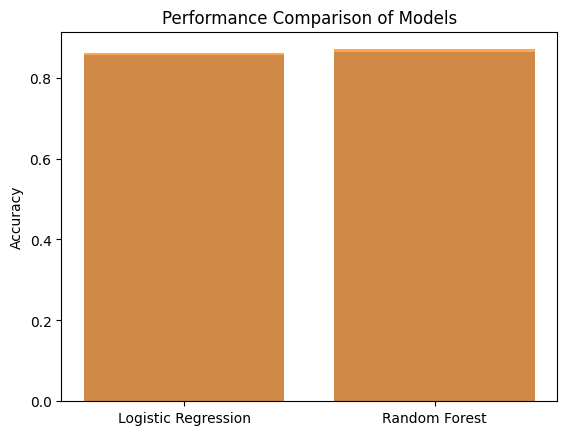

In [98]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Random Forest']
test_accuracies = [log_test_accuracy, rf_test_accuracy]
cv_accuracies = [0.86, 0.87] 

plt.bar(models, test_accuracies, label='Test Accuracy', alpha=0.7)
plt.bar(models, cv_accuracies, label='Cross-Validation Accuracy', alpha=0.7)
plt.title("Performance Comparison of Models")
plt.ylabel("Accuracy")
plt.show()


In [99]:

y_pred_rf = best_rf_model.predict(X_test_rf)
y_pred_rf_proba = best_rf_model.predict_proba(X_test_rf)[:, 1]

print("Random Forest Classification Report:\n")
print(classification_report(y_test_rf, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test_rf, y_pred_rf))



Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       151
           1       0.88      0.73      0.80        90

    accuracy                           0.86       241
   macro avg       0.87      0.84      0.85       241
weighted avg       0.86      0.86      0.86       241

Confusion Matrix:
[[142   9]
 [ 24  66]]


In [100]:
import numpy as np
misclassified_indices = np.where(y_test_rf != y_pred_rf)
print("Misclassified Samples (Random Forest):")
print(X_test_rf.iloc[misclassified_indices])


Misclassified Samples (Random Forest):
     Salary_log  Sex_male  Embarked_Q  Embarked_S  HasCabin  AgeGroup_encoded  \
364    0.707752       0.0         0.0         1.0         0                 4   
104    0.666719       0.0         0.0         1.0         0                 4   
153    0.782875       0.0         0.0         1.0         0                 0   
162    0.960171       0.0         0.0         0.0         1                 0   
813    0.955747       1.0         0.0         0.0         1                 6   
783    0.999772       1.0         0.0         1.0         1                 0   
812    0.769754       0.0         0.0         1.0         0                 4   
635    0.984209       1.0         0.0         1.0         1                 6   
639    0.940224       1.0         0.0         1.0         1                 0   
598    0.788706       1.0         0.0         1.0         0                 4   
757    0.850706       1.0         0.0         1.0         0           

In [101]:


y_pred_log = best_log_model.predict(X_test_log)
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test_log, y_pred_log))

print("Confusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test_log, y_pred_log))

import numpy as np
misclassified_indices_log = np.where(y_test_log != y_pred_log)
print("Misclassified Samples (Logistic Regression):")
print(X_test_log.iloc[misclassified_indices_log])


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       151
           1       0.86      0.73      0.79        90

    accuracy                           0.85       241
   macro avg       0.86      0.83      0.84       241
weighted avg       0.85      0.85      0.85       241

Confusion Matrix (Logistic Regression):
[[140  11]
 [ 24  66]]
Misclassified Samples (Logistic Regression):
     Salary_log  Sex_male  Embarked_Q  Embarked_S  HasCabin  AgeGroup_encoded  \
364    0.707752       0.0         0.0         1.0         0                 4   
104    0.666719       0.0         0.0         1.0         0                 4   
153    0.782875       0.0         0.0         1.0         0                 0   
162    0.960171       0.0         0.0         0.0         1                 0   
310    0.916028       1.0         0.0         1.0         1                 1   
63     0.741713       0.0         0

AUC-ROC: 0.91


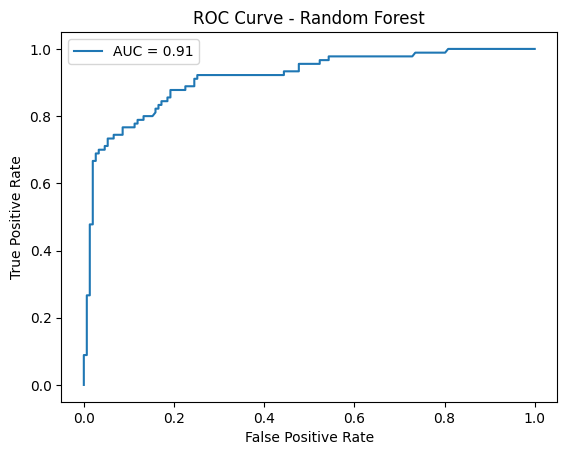

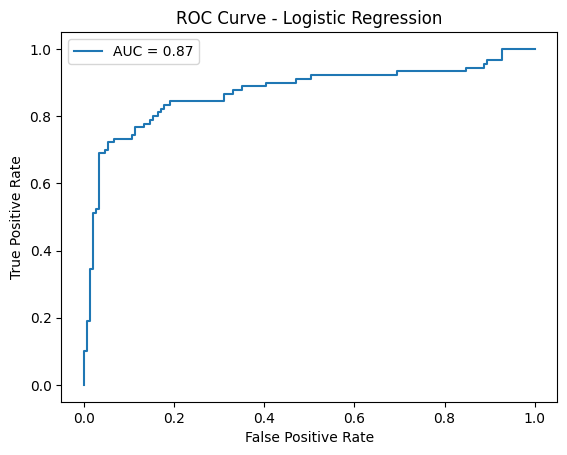

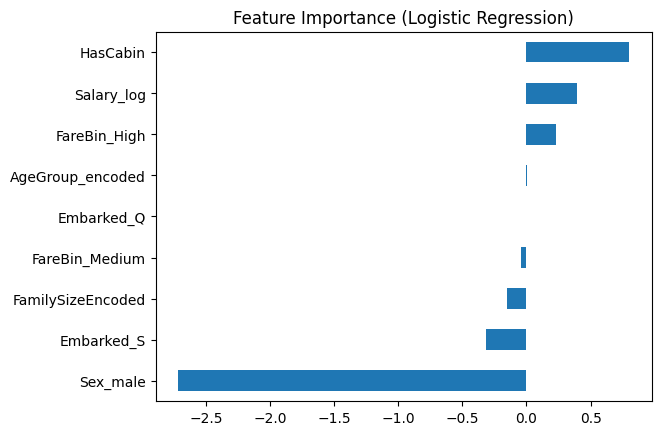

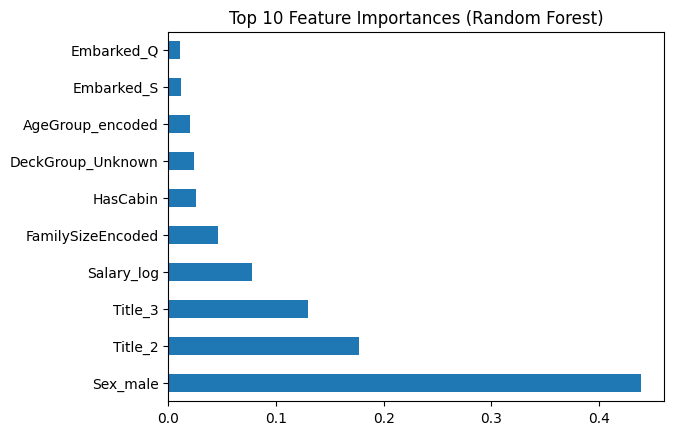

['random_forest_titanic.pkl']

In [102]:
roc_auc = roc_auc_score(y_test_rf, y_pred_rf_proba)
print(f"AUC-ROC: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test_rf, y_pred_rf_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

y_pred_log_proba = best_log_model.predict_proba(X_test_log)[:, 1]
roc_auc_log = roc_auc_score(y_test_log, y_pred_log_proba)
fpr_log, tpr_log, _ = roc_curve(y_test_log, y_pred_log_proba)

plt.plot(fpr_log, tpr_log, label=f"AUC = {roc_auc_log:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


log_coefficients = pd.Series(best_log_model.coef_[0], index=X_logistic.columns)
log_coefficients.sort_values().plot(kind='barh', title="Feature Importance (Logistic Regression)")
plt.show()

importances = pd.Series(best_rf_model.feature_importances_, index=X_rf.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

joblib.dump(best_log_model, 'logistic_regression_titanic.pkl')
joblib.dump(best_rf_model, 'random_forest_titanic.pkl')